In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
from keras.preprocessing import image

Using TensorFlow backend.


In [4]:
files = glob('../model/model/datasets/subject*')

In [5]:
# easier to randomize later
np.random.shuffle(files)

In [6]:
# number of samples
N = len(files)
N

166

In [7]:
H, W = 120, 160
def load_img(filepath):
  # load image and downsample
  img = image.img_to_array(image.load_img(filepath, target_size=[H, W])).astype('uint8')
  return img

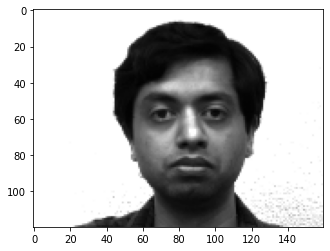

In [8]:
# loot at an image for fun
img = load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [9]:
img.shape

(120, 160, 3)

In [10]:
img.max()

255

In [11]:
def to_grayscale(img):
    return img.mean(axis=-1)

In [12]:
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [13]:
# load images as arrays
shape = (N,H,W)
images = np.zeros(shape)
for i, f in enumerate(files):
    img = to_grayscale(load_img(f)) / 255.
    images[i] = img

In [14]:
# make the labels
# all the filenames are something like 'subject12.happy'
labels = np.zeros(N)
for i, f in enumerate(files):
    filename = f.rsplit('\\', 1)[-1]
    subject_num = filename.split('.', 1)[0]    
    
    # subtract 1 since the filenames start from 1
    idx = int( subject_num.replace('subject', '') ) - 1
    labels[i] = idx

In [15]:
label_count = Counter(labels)
label_count

Counter({10.0: 11,
         3.0: 11,
         8.0: 11,
         7.0: 11,
         2.0: 11,
         9.0: 11,
         13.0: 11,
         12.0: 11,
         0.0: 12,
         5.0: 11,
         11.0: 11,
         6.0: 11,
         14.0: 11,
         1.0: 11,
         4.0: 11})

In [16]:
unique_labels = set(label_count.keys())

In [17]:
# get the number of subjects
n_subjects = len(label_count)

In [18]:
# let's make it so 3 images for each subject are test data
# number of test points is then
n_test = 3*n_subjects
n_train = N - n_test

In [19]:
# initialize arrays to hold train and test images
train_images = np.zeros((n_train, H, W))
train_labels = np.zeros(n_train)
test_images = np.zeros((n_test, H, W))
test_labels = np.zeros(n_test)

In [20]:
count_so_far = {}
train_idx = 0
test_idx = 0
images, labels = shuffle(images, labels)
for img, label in zip(images, labels):
    # increment the count
    count_so_far[label] = count_so_far.get(label,0) + 1
    
    if count_so_far[label] > 3:
        # we have already added 3 test images for this subject
        # so add the rest to train
        
        train_images[train_idx] = img
        train_labels[train_idx] = label
        train_idx += 1
        
    else:
        # add the first 3 images to test
        test_images[test_idx] = img
        test_labels[test_idx] = label
        test_idx += 1

In [21]:
# create label2idx mapping for easy access
train_label2idx = {}
test_label2idx = {}

for i, label in enumerate(train_labels):
    if label not in train_label2idx:
        train_label2idx[label] = [i]
    else:
        train_label2idx[label].append(i)
        
for i, label in enumerate(test_labels):
    if label not in test_label2idx:
        test_label2idx[label] = [i]
    else:
        test_label2idx[label].append(i)

In [22]:
# come up with all possible training sample indices
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label, indices in train_label2idx.items():
    # all indieces that do NOT belong to this subject
    other_indices = set(range(n_train)) - set(indices)
    
    for i, idx1 in enumerate(indices):
        for idx2 in indices[i+1:]:
            train_positives.append((idx1,idx2))
            
        for idx2 in other_indices:
            train_negatives.append((idx1,idx2))
            
for label, indices in test_label2idx.items():
    # all indices that do NOT belong to this subject
    other_indices = set(range(n_test)) - set(indices)
    
    for i, idx1 in enumerate(indices):
        for idx2 in indices[i+1:]:
            test_positives.append((idx1,idx2))
            
        for idx2 in other_indices:
            test_negatives.append((idx1,idx2))

In [23]:
batch_size = 16
def train_generator():
    # for each batch, we will send 1 pair of each subject
    # and the same number of non-matching pairs
    n_batches = int(np.ceil(len(train_positives) / batch_size))
    
    while True:
        np.random.shuffle(train_positives)
        n_samples = batch_size * 2
        shape = (n_samples, H, W)
        x_batch_1 = np.zeros(shape)
        x_batch_2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)
        
        for i in range(n_batches):
            pos_batch_indices = train_positives[ i*batch_size: (i+1)*batch_size]
            
            # fill up x_batch and y_batch
            j = 0
            for idx1, idx2 in pos_batch_indices:
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 1 # match
                j += 1
                
            # get negative samples
            neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=False)
            for neg in neg_indices:
                idx1, idx2 = train_negatives[neg]
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 0 # non-match
                j += 1
                
            x1 = x_batch_1[:j]
            x2 = x_batch_2[:j]
            y = y_batch[:j]
            
            # reshape
            x1 = x1.reshape(-1, 1, H, W)
            x2 = x2.reshape(-1, 1, H, W)
            
            # convert to torch tensor
            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            
            yield [x1, x2], y

In [24]:
# same thing as the train generator except no shuffling and it uses the test set
def test_generator():
    n_batches = int(np.ceil(len(test_positives) / batch_size ))
    
    while True:
        n_samples = batch_size * 2
        shape = (n_samples, H, W)
        x_batch_1 = np.zeros(shape)
        x_batch_2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)
                    
        for i in range(n_batches):
            pos_batch_indices = test_positives[i*batch_size: (i+1)*batch_size]
                    
            # fill up x_batch and y_batch
            j = 0
            for idx1, idx2 in pos_batch_indices:
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 1 # match
                j += 1
                    
            # get negative samples
            neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)
            for neg in neg_indices:
                idx1, idx2 = test_negatives[neg]
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 0
                j += 1
                    
            x1 = x_batch_1[:j]
            x2 = x_batch_2[:j]
            y = y_batch[:j]
            
            # reshape
            x1 = x1.reshape(-1, 1, H, W)
            x2 = x2.reshape(-1, 1, H, W)
            
            # convert to torch tensor
            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            
            yield [x1, x2], y

In [25]:
# build the model
class SiameseNN(nn.Module):
    def __init__(self,feature_dim):
        super(SiameseNN, self).__init__()
        
        # define CNN featurizer
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 32 > 16 > 8 > 4
            nn.Linear(15*20*128,256), # 120 > 60 > 30 > 15, 160>80>40>20
            #nn.Linear(15*20*64,128), # 120 > 60 > 30 > 15, 160>80>40>20
            nn.ReLU(),
            nn.Linear(256, feature_dim),
        )
        
    def forward(self, im1, im2):
        feat1 = self.cnn(im1)
        feat2 = self.cnn(im2)
        
        # Euclidean distance between feature 1 and feature 2
        return torch.norm(feat1 - feat2, dim=-1)

In [26]:
model = SiameseNN(128)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
model.to(device)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [28]:
# loss function for siamese network
def contrastive_loss(y,t):
    nonmatch = F.relu(1-y) # max(margin-y,0)
    return torch.mean( t*y**2 + (1-t)*nonmatch**2)

In [29]:
# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters())

In [30]:
# A function to encapsulate the training loop
def batch_gd(
    model,
    criterion,
    optimizer,
    train_gen,
    test_gen,
    train_steps_per_epoch,
    test_steps_per_epoch,
    epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        steps = 0
        for (x1,x2), targets in train_gen:
            # mode data to GPU
            x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x1, x2)
            loss = criterion(outputs, targets)
            
            # Backward and optimizer
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            # Update steps
            steps += 1
            if steps >= train_steps_per_epoch:
                break
                
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
            
        model.eval()
        test_loss = []
        steps = 0
        for(x1, x2), targets in test_gen:
                
            x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
            outputs = model(x1, x2)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            steps += 1
            if steps >= train_steps_per_epoch:
                break
        test_loss = np.mean(test_loss)
            
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
            
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
        Test Loss: {test_loss:.4f}, Duration: {dt}')
            
    return train_losses, test_losses

In [31]:
train_steps = int(np.ceil(len(train_positives) / batch_size))
test_steps = int(np.ceil(len(test_positives) / batch_size))

train_losses, test_losses = batch_gd(
    model,
    contrastive_loss,
    optimizer,
    train_generator(),
    test_generator(),
    train_steps,
    test_steps,
    epochs=20)

Epoch 1/20, Train Loss: 4.8986,         Test Loss: 1.7496, Duration: 0:00:06.643232
Epoch 2/20, Train Loss: 0.7022,         Test Loss: 0.4915, Duration: 0:00:05.326759
Epoch 3/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.309801
Epoch 4/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.357676
Epoch 5/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.363661
Epoch 6/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.373631
Epoch 7/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.351690
Epoch 8/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.373632
Epoch 9/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.355680
Epoch 10/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.371652
Epoch 11/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00:05.366650
Epoch 12/20, Train Loss: 0.5000,         Test Loss: 0.5000, Duration: 0:00

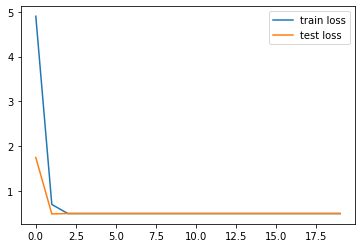

In [32]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [33]:
model.eval()

SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [34]:
# Convenience function to make predictions
def predict(x1, x2):
  x1 = torch.from_numpy(x1).float().to(device)
  x2 = torch.from_numpy(x2).float().to(device)
  with torch.no_grad():
    dist = model(x1, x2).cpu().numpy()
    return dist.flatten()

In [35]:
# calculate accuracy before training
# since the dataset is imbalanced, we'll report tp, tn, fp, fn
def get_train_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(train_positives) / batch_size))
  for i in range(n_batches):
    #print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = train_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(train_negatives) / batch_size))
  for i in range(n_batches):
    #print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = train_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j,0] = train_images[idx1]
      x_batch_2[j,0] = train_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()

  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

In [36]:
def get_test_accuracy(threshold=0.85):
  positive_distances = []
  negative_distances = []

  tp = 0
  tn = 0
  fp = 0
  fn = 0

  batch_size = 64
  x_batch_1 = np.zeros((batch_size, 1, H, W))
  x_batch_2 = np.zeros((batch_size, 1, H, W))
  n_batches = int(np.ceil(len(test_positives) / batch_size))
  for i in range(n_batches):
    #print(f"pos batch: {i+1}/{n_batches}")
    pos_batch_indices = test_positives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in pos_batch_indices:
      x_batch_1[j,0] = test_images[idx1]
      x_batch_2[j,0] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    positive_distances += distances.tolist()

    # update tp, tn, fp, fn
    tp += (distances < threshold).sum()
    fn += (distances > threshold).sum()

  n_batches = int(np.ceil(len(test_negatives) / batch_size))
  for i in range(n_batches):
    #print(f"neg batch: {i+1}/{n_batches}")
    neg_batch_indices = test_negatives[i * batch_size: (i + 1) * batch_size]

    # fill up x_batch and y_batch
    j = 0
    for idx1, idx2 in neg_batch_indices:
      x_batch_1[j] = test_images[idx1]
      x_batch_2[j] = test_images[idx2]
      j += 1

    x1 = x_batch_1[:j]
    x2 = x_batch_2[:j]
    distances = predict(x1, x2)
    negative_distances += distances.tolist()

    # update tp, tn, fp, fn
    fp += (distances < threshold).sum()
    tn += (distances > threshold).sum()


  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)
  print(f"sensitivity (tpr): {tpr}, specificity (tnr): {tnr}")

  plt.hist(negative_distances, bins=20, density=True, label='negative_distances')
  plt.hist(positive_distances, bins=20, density=True, label='positive_distances')
  plt.legend()
  plt.show()

sensitivity (tpr): 1.0, specificity (tnr): 0.0


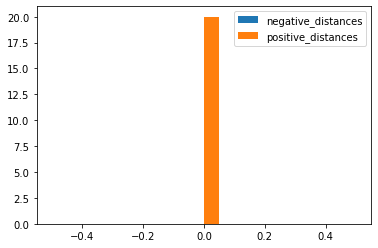

In [37]:
get_train_accuracy(0.85)

sensitivity (tpr): 1.0, specificity (tnr): 0.0


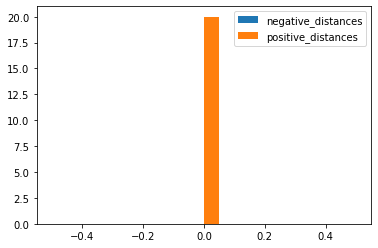

In [38]:
get_test_accuracy(0.85)